In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None
np.set_printoptions(precision=2)

congest_range = [0.8,1.0,1.2]
demand_range = [1,2,4]
supply_range = [0.5,0.75,1.0,1.25]
prate_range = [0.4,0.6,0.8]
tax_c_range = [0.0,-0.025]
tax_d_range = [0.0,-0.25]

background_2 = np.array([[1.66624,0.844234],
                       [1.63102,0.844325],
                       [1.75545,0.844088],
                       [2.27241,0.831749],
                       [2.18577,0.8338],
                       [2.24245,0.833779],
                       [3.06258,0.814826],
                       [2.91992,0.817789],
                       [3.03846,0.816685]
                      ])

background_5 = np.array([[1.66237,0.744609],
                       [1.61874,0.746974],
                       [1.64893,0.745562],
                       [2.27728,0.72454],
                       [2.19605,0.726586],
                       [2.25923,0.725667],
                       [3.08755,0.698895],
                       [2.97623,0.701193],
                       [3.16812,0.699723]
                      ])

In [2]:
def load(path):
    table = pd.read_csv(path,
                     names = ["strategy","congestion","demand","supply","prate","tax_cong","tax_demand",
                            "private","revenue","cost","tax","profit","total_pax",
                            "single_pax","shared_pax","ave_pax","ave_dist","ave_time",
                            "public","ave_link_time","ave_density","total_demand",
                            "serviced_demand","stay_demand","trip_rate",
                            "ave_taxi_dist","ave_shared_dist","ave_stay_dist","ave_exit_dist",
                            "ave_time_offer","ave_time_offer_s","ave_time_pickup"])
    del table['public'],table['private']
    table['shared_rate'] = table['shared_pax'] / table['serviced_demand']
    table['total_shared_rate'] = table['shared_pax'] / (table['serviced_demand'] + table['stay_demand'])
    table['ave_single_dist'] = (table['ave_taxi_dist'] * table['single_pax'] + \
                                table['ave_stay_dist'] * table['stay_demand']) / \
                               (table['single_pax'] + table['stay_demand']) 
    table['reduce_dist'] = table['ave_taxi_dist'] * table['single_pax'] + \
                           table['ave_shared_dist'] * table['shared_pax'] - \
                           (table['ave_dist'] * table['supply'] * 1000)
    return table

def get_pri_comp(result):
    result_col = ["profit","revenue","cost","ave_pax","ave_dist","ave_time",'ave_time_offer','ave_time_pickup']
    compare_stra = np.zeros((len(result_col),5))
    count = 0
    for congest in congest_range:
        for demand in demand_range:
            for supply in supply_range:
                for prate in prate_range:
                    count += 1
                    temp = result.loc[(result['congestion'] == congest) & (result['demand'] == demand) & \
                                      (result['supply'] == supply) & (result['prate'] == prate) & \
                                      (result['tax_cong'] == 0.0) & (result['tax_demand'] == 0.0),:]
                    pricing_opt_temp = np.asarray(temp.loc[(temp['strategy'] == "Pricing Opt"),result_col])[0,:]
                    full_temp = np.asarray(temp.loc[(temp['strategy'] == "Full"),result_col])[0,:]
                    single_temp = np.asarray(temp.loc[(temp['strategy'] == "Single"),result_col])[0,:]
                    shared_temp = np.asarray(temp.loc[(temp['strategy'] == "Pool"),result_col])[0,:]
                    assort_temp = np.asarray(temp.loc[(temp['strategy'] == "Assort"),result_col])[0,:]
                    price_temp = np.asarray(temp.loc[(temp['strategy'] == "Pricing"),result_col])[0,:]
                    compare_stra[:,0] += ((full_temp - pricing_opt_temp) / pricing_opt_temp) * 100
                    compare_stra[:,1] += ((single_temp - pricing_opt_temp) / pricing_opt_temp) * 100
                    compare_stra[:,2] += ((shared_temp - pricing_opt_temp) / pricing_opt_temp) * 100
                    compare_stra[:,3] += ((assort_temp - pricing_opt_temp) / pricing_opt_temp) * 100
                    compare_stra[:,4] += ((price_temp - pricing_opt_temp) / pricing_opt_temp) * 100

    compare_stra = compare_stra / count
    return compare_stra

def get_sys_out(result,background):
    result_col = ["ave_link_time","trip_rate"]
    compare_stra = np.zeros((len(congest_range) * len(demand_range),6))
    row_id = -1
    for congest in congest_range:
        for demand in demand_range:
            row_id += 1
            background_temp = background[row_id,:]
            for supply in supply_range:
                for prate in prate_range:
                    temp = result.loc[(result['congestion'] == congest) & (result['demand'] == demand) & \
                                      (result['supply'] == supply) & (result['prate'] == prate) & \
                                      (result['tax_cong'] == 0.0) & (result['tax_demand'] == 0.0),:]
                    full_temp = np.asarray(temp.loc[(temp['strategy'] == "Full"),result_col])[0,:]
                    shared_temp = np.asarray(temp.loc[(temp['strategy'] == "Pool"),result_col])[0,:]
                    pricing_opt_temp = np.asarray(temp.loc[(temp['strategy'] == "Pricing Opt"),result_col])[0,:]
                    compare_stra[row_id,[0,3]] += ((full_temp - background_temp) / background_temp) * 100
                    compare_stra[row_id,[1,4]] += ((shared_temp - background_temp) / background_temp) * 100
                    compare_stra[row_id,[2,5]] += ((pricing_opt_temp - background_temp) / background_temp) * 100

    compare_stra = compare_stra / (len(supply_range) * len(prate_range))
    return compare_stra

def get_sys_out_wtax(result,background):
    result_col = ["ave_link_time","trip_rate"]
    compare_stra = np.zeros((len(congest_range),10))
    row_id = -1
    for congest in congest_range:
        row_id += 1
        background_temp = background[row_id*3+2,:]
        for supply in supply_range:
            for prate in prate_range:
                temp = result.loc[(result['congestion'] == congest) & (result['demand'] == 4) & \
                                  (result['supply'] == supply) & (result['prate'] == prate),:]
                full_temp = np.asarray(temp.loc[(result['strategy'] == "Full") & \
                                  (temp['tax_cong'] == 0.0) & (temp['tax_demand'] == 0.0),result_col])[0,:]
                shared_temp = np.asarray(temp.loc[(result['strategy'] == "Pool") & \
                                  (temp['tax_cong'] == 0.0) & (temp['tax_demand'] == 0.0),result_col])[0,:]
                pricing_opt_temp = np.asarray(temp.loc[(temp['strategy'] == "Pricing Opt") & \
                                  (temp['tax_cong'] == 0.0) & (temp['tax_demand'] == 0.0),result_col])[0,:]
                po_trc_temp = np.asarray(temp.loc[(temp['strategy'] == "Pricing Opt") & \
                                  (temp['tax_cong'] == -0.025) & (temp['tax_demand'] == 0.0),result_col])[0,:]
                po_trd_temp = np.asarray(temp.loc[(temp['strategy'] == "Pricing Opt") & \
                                  (temp['tax_cong'] == 0.0) & (temp['tax_demand'] == -0.25),result_col])[0,:]
                
                compare_stra[row_id,[0,5]] += ((full_temp - background_temp) / background_temp) * 100
                compare_stra[row_id,[1,6]] += ((shared_temp - background_temp) / background_temp) * 100
                compare_stra[row_id,[2,7]] += ((pricing_opt_temp - background_temp) / background_temp) * 100
                compare_stra[row_id,[3,8]] += ((po_trc_temp - background_temp) / background_temp) * 100
                compare_stra[row_id,[4,9]] += ((po_trd_temp - background_temp) / background_temp) * 100

    compare_stra = compare_stra /  (len(supply_range) * len(prate_range))
    return compare_stra

In [3]:
def get_sub_table(re,background,i_cong,i_demand):
    re_s = re.loc[(re['congestion'] == congest_range[i_cong]) & (re['demand'] == demand_range[i_demand]),:]
    background_s = background[(i_cong * len(demand_range) + i_demand),:]
    re_s['ave_link_time_pc'] = (re_s['ave_link_time'] / background_s[0] - 1) * 100
    re_s['trip_rate_pc'] = (re_s['trip_rate']/background_s[1] - 1) * 100
    return re_s

def get_sys_out_sub(re_s,result_col):
    compare_stra = np.zeros((len(supply_range) * len(prate_range),3 * len(result_col)))
    row_id = -1
    count = 0
    col_id = np.arange(len(result_col)) * 3
    for supply in supply_range:
        for prate in prate_range:
            row_id += 1
            temp = re_s.loc[(re_s['supply'] == supply) & (re_s['prate'] == prate) & \
                            (re_s['tax_cong'] == 0.0) & (re_s['tax_demand'] == 0.0),:]
            compare_stra[row_id,col_id] = np.asarray(temp.loc[(temp['strategy'] == "Full"),result_col])[0,:]
            compare_stra[row_id,col_id + 1] = np.asarray(temp.loc[(temp['strategy'] == "Pool"),result_col])[0,:]
            compare_stra[row_id,col_id + 2] = np.asarray(temp.loc[(temp['strategy'] == "Pricing Opt"),result_col])[0,:]
            
    return compare_stra

def get_detail_table(re_s,property_name):
    re_out = np.zeros((5,len(prate_range),len(supply_range)))
    col_id = -1
    for supply in supply_range:
        col_id += 1
        row_id = -1
        for prate in prate_range:
            row_id += 1
            re_temp = re_s.loc[(re_s['supply'] == supply) & (re_s['prate'] == prate) &\
                               (re_s['tax_cong'] == 0.0) & (re_s['tax_demand'] == 0.0),['strategy',property_name]]
            re_out[0,row_id,col_id] = np.asarray(re_temp.loc[(re_temp['strategy'] == "Full"),[property_name]])[0]
            re_out[1,row_id,col_id] = np.asarray(re_temp.loc[(re_temp['strategy'] == "Pool"),[property_name]])[0]
            re_out[2,row_id,col_id] = np.asarray(re_temp.loc[(re_temp['strategy'] == "Pricing Opt"),
                                                             [property_name]])[0]
            re_out[3,row_id,col_id] = np.asarray(re_s.loc[(re_s['supply'] == supply) & (re_s['prate'] == prate) &\
                                                     (re_s['tax_cong'] == -0.025) & (re_s['tax_demand'] == 0.0) &\
                                                     (re_s['strategy'] == "Pricing Opt"),[property_name]])[0]
            re_out[4,row_id,col_id] = np.asarray(re_s.loc[(re_s['supply'] == supply) & (re_s['prate'] == prate) &\
                                                     (re_s['tax_cong'] == 0.0) & (re_s['tax_demand'] == -0.25) &\
                                                     (re_s['strategy'] == "Pricing Opt"),[property_name]])[0]
    return re_out

def get_tax_c_eff(re_s,name):
    re_out = np.zeros((len(prate_range),len(supply_range)))
    col_id = -1
    for supply in supply_range:
        col_id += 1
        row_id = -1
        for prate in prate_range:
            row_id += 1
            temp = re_s.loc[(re_s['supply'] == supply) & (re_s['prate'] == prate) & \
                            (re_s['tax_demand'] == 0.0),['strategy','tax_cong',name]]
            temp1 = np.asarray(temp.loc[(temp['tax_cong'] == tax_c_range[1]) & \
                                        (temp['strategy'] == "Pricing Opt"),name])[0]
            temp2 = np.asarray(temp.loc[(temp['tax_cong'] == tax_c_range[0]) & \
                                        (temp['strategy'] == "Pricing Opt"),name])[0]
            re_out[row_id,col_id] += (float(temp1)/float(temp2) - 1) * 100
                
    return re_out

def get_tax_d_eff(re_s,name):
    re_out = np.zeros((len(prate_range),len(supply_range)))
    col_id = -1
    for supply in supply_range:
        col_id += 1
        row_id = -1
        for prate in prate_range:
            row_id += 1
            temp = re_s.loc[(re_s['supply'] == supply) & (re_s['prate'] == prate) & \
                            (re_s['tax_cong'] == 0.0),['strategy','tax_demand',name]]
            temp1 = np.asarray(temp.loc[(temp['tax_demand'] == tax_d_range[1]) & \
                                        (temp['strategy'] == "Pricing Opt"),name])[0]
            temp2 = np.asarray(temp.loc[(temp['tax_demand'] == tax_d_range[0]) & \
                                        (temp['strategy'] == "Pricing Opt"),name])[0]
            re_out[row_id,col_id] += (float(temp1)/float(temp2) - 1) * 100
                
    return re_out

In [4]:
re_2 = load("results_dyna_2.csv")
re_5 = load("results_dyna_5.csv")

In [14]:
print "Private metrics 1: \n",get_pri_comp(re_2)[:6,:],"\n"
print "Private metrics 2: \n",get_pri_comp(re_2)[6:,:],"\n"
print "System metrics: \n",get_sys_out(re_2,background_2)

Private metrics 1: 
[[-11.18 -39.51 -26.1  -10.89 -11.45]
 [ -7.99 -39.32 -22.61  -8.63  -8.22]
 [  7.8  -37.81  -5.61   2.75   8.42]
 [ 22.09 -44.14  15.4   17.02  16.78]
 [  7.8  -37.81  -5.61   2.75   8.42]
 [ 12.4  -30.54  -2.54   7.75  12.16]] 

Private metrics 2: 
[[ 2818.08  2865.81  1347.01  2788.1   3997.43]
 [   13.65    -8.39    10.7     12.54    13.31]] 

System metrics: 
[[  0.91   0.56   0.87   9.27   8.5    7.98]
 [  1.83   0.95   1.87   9.23   8.5    7.99]
 [  4.86  -0.35   5.71   8.74   8.25   7.62]
 [  0.92   0.51   0.95   9.01   8.38   7.71]
 [  2.04   0.97   2.08   8.76   8.18   7.51]
 [ 12.35   4.45  14.41   7.96   7.85   6.87]
 [  1.41   0.89   1.22   8.26   7.82   7.14]
 [  3.36   1.99   3.14   7.93   7.6    6.94]
 [ 23.52  10.22  19.58   6.42   7.11   5.37]]


In [15]:
print "Private metrics 1: \n",get_pri_comp(re_5)[:6,:],"\n"
print "Private metrics 2: \n",get_pri_comp(re_5)[6:,:],"\n"
print "System metrics: \n",get_sys_out(re_5,background_5)

Private metrics 1: 
[[-16.8  -36.01 -25.52 -16.51 -14.9 ]
 [-13.01 -33.98 -21.65 -14.29 -11.75]
 [  7.58 -21.96  -0.94  -1.87   5.86]
 [ 25.51 -35.68  24.03   7.24  17.42]
 [  7.58 -21.96  -0.94  -1.87   5.86]
 [ 14.05 -13.31   4.01   5.98  12.07]] 

Private metrics 2: 
[[ 3540.55  5694.81  2086.42  4238.45  4492.09]
 [   17.71     6.03    14.01    18.47    17.94]] 

System metrics: 
[[  1.81   1.38   1.78  20.23  19.27  17.15]
 [  4.13   3.03   4.21  19.7   18.83  16.72]
 [ 14.23   9.4   16.55  18.76  18.34  15.93]
 [  1.98   1.5    2.05  19.45  18.89  16.18]
 [  4.8    3.55   4.97  18.85  18.46  15.8 ]
 [ 28.58  17.07  27.55  16.01  16.87  13.8 ]
 [  2.79   2.17   2.41  17.27  17.3   15.25]
 [  7.52   5.63   6.51  16.18  16.58  14.11]
 [ 47.96  31.9   34.16  10.15  12.82  10.72]]


In [7]:
i_cong = 2
i_demand = 2
re_2_s = get_sub_table(re_2,background_2,i_cong,i_demand)
re_5_s = get_sub_table(re_5,background_5,i_cong,i_demand)

In [8]:
print "System metrics: \n",get_sys_out_sub(re_2_s,["ave_link_time_pc","trip_rate_pc"])
print "Detail results: \n",get_sys_out_sub(re_2_s,["total_shared_rate","reduce_dist"])
print "Total shared rate: \n",get_sys_out_sub(re_2_s,["total_shared_rate"])
print "Total reduced distance: \n",get_sys_out_sub(re_2_s,["reduce_dist"])

System metrics: 
[[  2.    -2.45  13.79   6.88   7.35   4.15]
 [  4.64  -1.69   5.06   5.96   6.57   4.89]
 [  7.96   1.37   4.43   5.07   5.6    5.61]
 [  6.17  -0.42  16.01   8.23   8.89   4.72]
 [ 13.09   4.25   8.26   6.84   7.52   6.59]
 [ 19.93  10.75  14.87   5.55   5.84   5.45]
 [ 18.42   7.08  23.1    8.52   9.27   6.17]
 [ 27.74  14.14  29.47   6.82   7.41   6.02]
 [ 37.75  19.05  40.59   5.2    5.66   5.1 ]
 [ 35.87  17.43  26.91   8.03   9.03   4.63]
 [ 47.8   23.41  33.28   5.98   7.06   4.9 ]
 [ 60.85  29.69  19.26   3.97   5.17   6.25]]
Detail results: 
[[  3.56e-01   4.02e-01   1.82e-01   1.06e+05   1.23e+05   3.80e+04]
 [  3.07e-01   3.67e-01   1.69e-01   7.78e+04   9.70e+04   3.35e+04]
 [  2.54e-01   3.28e-01   2.75e-01   5.07e+04   7.17e+04   6.71e+04]
 [  4.04e-01   4.73e-01   1.49e-01   1.11e+05   1.32e+05   3.00e+04]
 [  3.39e-01   4.22e-01   2.77e-01   7.55e+04   9.89e+04   6.69e+04]
 [  2.76e-01   3.63e-01   2.05e-01   4.55e+04   7.24e+04   4.35e+04]
 [  4.21e-0

In [9]:
print "System metrics: \n",get_sys_out_sub(re_5_s,["ave_link_time_pc","trip_rate_pc"])
print "Detail results: \n",get_sys_out_sub(re_5_s,["total_shared_rate","reduce_dist"])
print "Total shared rate: \n",get_sys_out_sub(re_5_s,["total_shared_rate"])
print "Total reduced distance: \n",get_sys_out_sub(re_5_s,["reduce_dist"])

System metrics: 
[[ 14.18   8.96  25.55  11.76  12.91   7.25]
 [ 15.27   9.76  21.1   10.55  11.79  10.27]
 [ 18.22  11.73  16.77   9.01  10.34  10.03]
 [ 25.23  19.46  21.77  14.    15.33  10.6 ]
 [ 31.98  22.1   26.06  11.67  13.42  12.76]
 [ 36.84  25.14  26.69   9.38  11.35  10.19]
 [ 48.86  37.06  39.01  13.42  15.61   9.72]
 [ 55.35  40.11  39.78  10.75  13.53  11.57]
 [ 62.22  40.2   45.06   8.    11.34  10.48]
 [ 79.14  60.16  44.71  10.96  14.65  11.26]
 [ 89.66  57.48  57.19   7.73  12.76  11.53]
 [ 98.6   50.59  46.2    4.53  10.76  13.02]]
Detail results: 
[[  3.99e-01   4.51e-01   1.85e-01   1.12e+05   1.32e+05   3.28e+04]
 [  3.57e-01   4.25e-01   3.04e-01   8.98e+04   1.14e+05   8.23e+04]
 [  3.08e-01   3.93e-01   2.88e-01   6.47e+04   9.17e+04   7.21e+04]
 [  4.53e-01   5.24e-01   2.77e-01   1.24e+05   1.49e+05   7.18e+04]
 [  3.95e-01   4.87e-01   3.97e-01   9.11e+04   1.21e+05   1.06e+05]
 [  3.33e-01   4.49e-01   2.76e-01   5.99e+04   9.41e+04   6.48e+04]
 [  4.69e-0

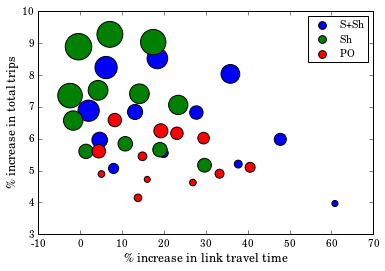

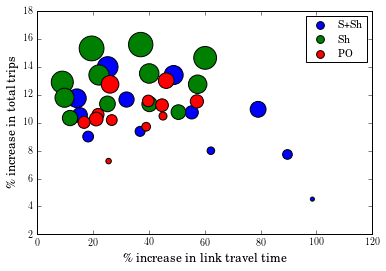

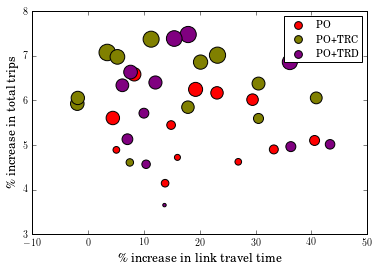

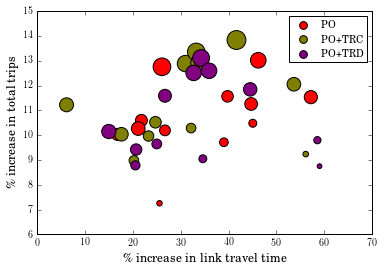

In [16]:
def plot_scale_stra(table,scale,i,fname):
    plt.figure()
    x_temp = get_detail_table(table,"ave_link_time_pc")[0,:,:].reshape((12,))
    y_temp = get_detail_table(table,"trip_rate_pc")[0,:,:].reshape((12,))
    s_temp = (get_detail_table(table,"reduce_dist")[0,:,:].reshape((12,)) * scale) ** 2
    p_full = plt.scatter(x_temp,y_temp,s=s_temp,c='b')

    x_temp = get_detail_table(table,"ave_link_time_pc")[1,:,:].reshape((12,))
    y_temp = get_detail_table(table,"trip_rate_pc")[1,:,:].reshape((12,))
    s_temp = (get_detail_table(table,"reduce_dist")[1,:,:].reshape((12,)) * scale) ** 2
    p_pool = plt.scatter(x_temp,y_temp,s=s_temp,c='g')

    x_temp = get_detail_table(table,"ave_link_time_pc")[2,:,:].reshape((12,))
    y_temp = get_detail_table(table,"trip_rate_pc")[2,:,:].reshape((12,))
    s_temp = (get_detail_table(table,"reduce_dist")[2,:,:].reshape((12,)) * scale) ** 2
    p_pricing_opt = plt.scatter(x_temp,y_temp,s=s_temp,c='r')
    
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    lgnd = plt.legend((p_full,p_pool,p_pricing_opt),
                       ("S+Sh","Sh","PO"),
                       scatterpoints=1,
                       fontsize=10)
    lgnd.legendHandles[0]._sizes = [60]
    lgnd.legendHandles[1]._sizes = [60]
    lgnd.legendHandles[2]._sizes = [60]
    plt.xlabel("\% increase in link travel time",fontsize=12)
    plt.ylabel("\% increase in total trips",fontsize=12)
    plt.savefig(fname)
    
def plot_scale_tax(table,scale,i,fname):
    plt.figure()
    x_temp = get_detail_table(table,"ave_link_time_pc")[2,:,:].reshape((12,))
    y_temp = get_detail_table(table,"trip_rate_pc")[2,:,:].reshape((12,))
    s_temp = (get_detail_table(table,"reduce_dist")[2,:,:].reshape((12,)) * scale) ** 2
    p_pricing_opt = plt.scatter(x_temp,y_temp,s=s_temp,c=(1,0,0))
    
    x_temp = get_detail_table(table,"ave_link_time_pc")[3,:,:].reshape((12,))
    y_temp = get_detail_table(table,"trip_rate_pc")[3,:,:].reshape((12,))
    s_temp = (get_detail_table(table,"reduce_dist")[3,:,:].reshape((12,)) * scale) ** 2
    p_opt_tax_c = plt.scatter(x_temp,y_temp,s=s_temp,c=(0.5,0.5,0))
    
    x_temp = get_detail_table(table,"ave_link_time_pc")[4,:,:].reshape((12,))
    y_temp = get_detail_table(table,"trip_rate_pc")[4,:,:].reshape((12,))
    s_temp = (get_detail_table(table,"reduce_dist")[4,:,:].reshape((12,)) * scale) ** 2
    p_opt_tax_d = plt.scatter(x_temp,y_temp,s=s_temp,c=(0.5,0,0.5))
    
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    lgnd = plt.legend((p_pricing_opt,p_opt_tax_c,p_opt_tax_d),
                       ("PO","PO+TRC","PO+TRD"),
                       scatterpoints=1,
                       fontsize=10)
    lgnd.legendHandles[0]._sizes = [60]
    lgnd.legendHandles[1]._sizes = [60]
    lgnd.legendHandles[2]._sizes = [60]
    plt.xlabel("\% increase in link travel time",fontsize=12)
    plt.ylabel("\% increase in total trips",fontsize=12)
    plt.savefig(fname)

plot_scale_stra(re_2_s,1.0/5000,5,"dyna_2_stra.eps")
plot_scale_stra(re_5_s,1.0/6000,5,"dyna_5_stra.eps")
plot_scale_tax(re_2_s,1.0/5000,5,"dyna_2_tax.eps")
plot_scale_tax(re_5_s,1.0/6000,5,"dyna_5_tax.eps")

In [17]:
result_col = ['ave_link_time','trip_rate']

print "Tax reduction in congestion: "
print "On total congestion: \n",get_tax_c_eff(re_2_s,result_col[0]),"\n"
print "On total capacity: \n",get_tax_c_eff(re_2_s,result_col[1]),"\n"

print "Tax reduction in demand: "
print "On total congestion: \n",get_tax_d_eff(re_2_s,result_col[0]),"\n"
print "On total capacity: \n",get_tax_d_eff(re_2_s,result_col[1]),"\n"

Tax reduction in congestion: 
On total congestion: 
[[-13.83   1.62   6.04  -2.93]
 [  2.3   -4.46  -7.2    5.7 ]
 [ -6.01  -8.37 -20.84   9.46]] 

On total capacity: 
[[ 1.71  1.07 -0.54  2.28]
 [-0.27  0.46  0.79  1.1 ]
 [ 0.43  1.45  2.16  0.12]] 

Tax reduction in demand: 
On total congestion: 
[[ -0.1   -5.18  10.75  -7.08]
 [  5.07  -0.6  -10.84   2.15]
 [  2.5   -7.6  -20.29  20.21]] 

On total capacity: 
[[-0.47  0.95 -1.13  2.73]
 [-0.31  0.05  1.29  1.87]
 [-0.45  0.84  1.24 -1.16]] 



In [18]:
print "Tax reduction in congestion: "
print "On total congestion: \n",get_tax_c_eff(re_5_s,result_col[0]),"\n"
print "On total capacity: \n",get_tax_c_eff(re_5_s,result_col[1]),"\n"

print "Tax reduction in demand: "
print "On total congestion: \n",get_tax_d_eff(re_5_s,result_col[0]),"\n"
print "On total capacity: \n",get_tax_d_eff(re_5_s,result_col[1]),"\n"

Tax reduction in congestion: 
On total congestion: 
[[ -4.27   8.53  -5.77   7.89]
 [-12.38  -2.23  -4.69  -2.26]
 [  0.7   -1.57  -7.77  -3.12]] 

On total capacity: 
[[ 1.61 -0.28  2.89 -1.82]
 [ 0.87 -2.48  1.61  0.47]
 [ 0.01  0.3   2.2   0.72]] 

Tax reduction in demand: 
On total congestion: 
[[ -4.01e+00   1.05e+01  -4.55e+00   9.88e+00]
 [ -3.62e-01  -8.62e-01  -3.95e+00   8.69e-01]
 [ -1.55e+00  -2.49e-04  -6.30e+00  -1.16e+00]] 

On total capacity: 
[[ 1.43 -1.4   2.55 -2.25]
 [-0.77 -2.76  1.38 -1.56]
 [ 0.11  1.27  1.92 -1.04]] 



In [6]:
print "System metrics w/ tax: \n",get_sys_out_wtax(re_2,background_2)
print "System metrics w/ tax: \n",get_sys_out_wtax(re_5,background_5)

System metrics w/ tax: 
[[  4.86  -0.35   5.71   3.9    3.36   8.74   8.25   7.62   7.81   7.96]
 [ 12.35   4.45  14.41   9.15   8.1    7.96   7.85   6.87   7.11   7.15]
 [ 23.52  10.22  19.58  15.57  18.01   6.42   7.11   5.37   6.31   5.85]]
System metrics w/ tax: 
[[ 14.23   9.4   16.55  13.07  14.08  18.76  18.34  15.93  16.19  15.94]
 [ 28.58  17.07  27.55  25.1   24.29  16.01  16.87  13.8   14.22  13.95]
 [ 47.96  31.9   34.16  31.12  33.94  10.15  12.82  10.72  11.27  10.6 ]]
